#** Modelo preditivo de regressão para prever o valor dos custos médicos individuais cobrados pelo seguro de saúde

In [620]:
# Importando as bibliotecas necessárias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score

Importando os dados


In [621]:
df = pd.read_csv("insurance.csv")


In [622]:
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


# Conhecendo os dados 🤓

In [623]:
df.shape

(1338, 7)

In [624]:
# Verificar a quantidade de valores nulos em cada coluna
print(df.isnull().sum())


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [625]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Existem 3 variáveis do tipo texto: sex, smoker, region. Vamos analisar a quantidade de categorias em cada uma delas.

In [626]:
set(df["sex"])

{'female', 'male'}

In [627]:
set(df["smoker"])

{'no', 'yes'}

In [628]:
df["smoker"].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [629]:
set(df["region"])

{'northeast', 'northwest', 'southeast', 'southwest'}

In [630]:
df["region"].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

Vamos ver algumas estatísticas:

In [631]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Analisando algumas distribuições com histogramas:

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

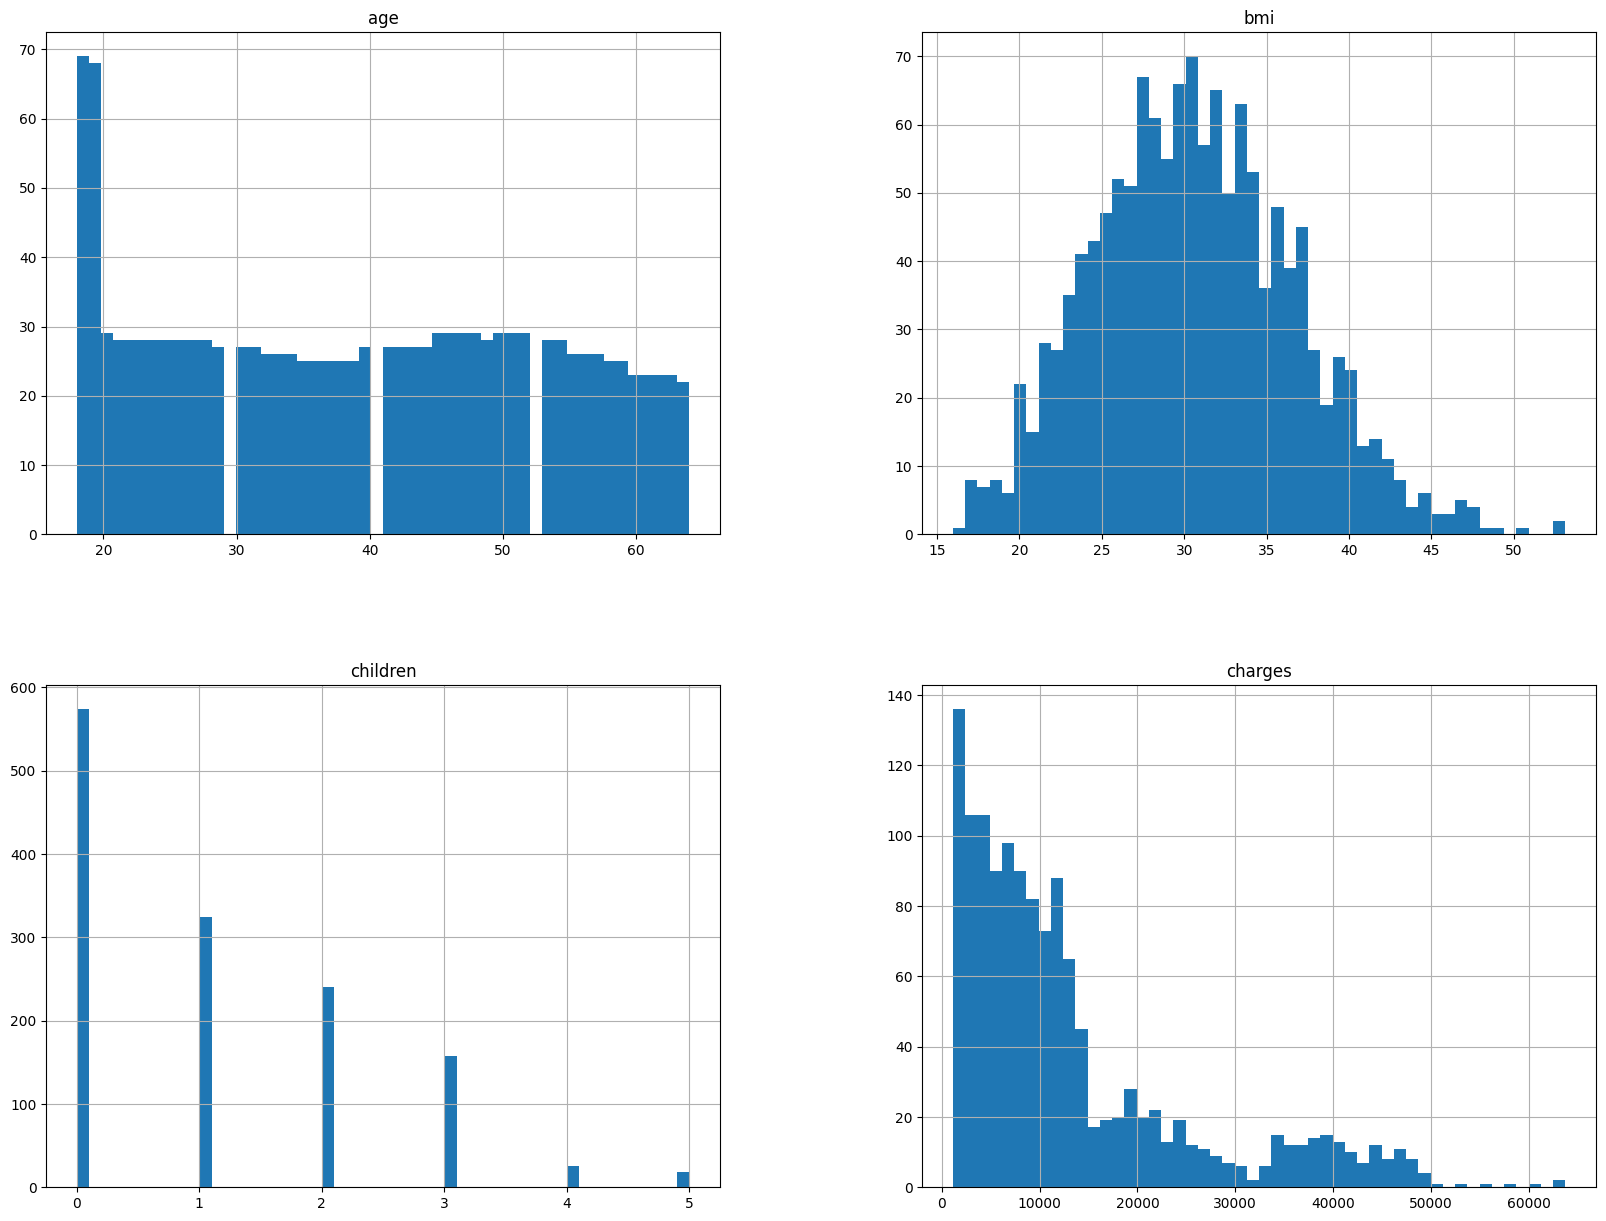

In [632]:
df.hist(bins=50, figsize=(20,15))

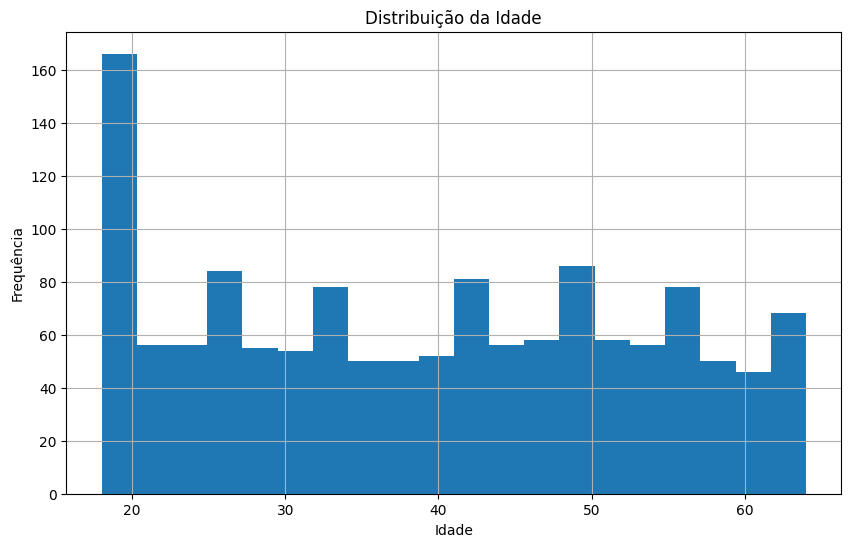

In [633]:
df["age"].hist(bins=20, figsize=(10, 6))
plt.xlabel("Idade")
plt.ylabel("Frequência")
plt.title("Distribuição da Idade")
plt.show()

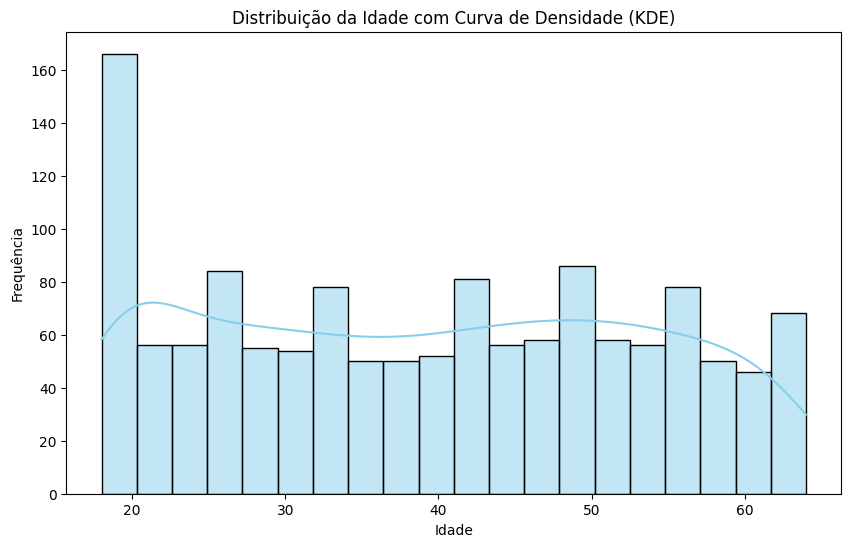

In [634]:
plt.figure(figsize=(10, 6))
sns.histplot(df["age"], bins=20, kde=True, color="skyblue")
plt.xlabel("Idade")
plt.ylabel("Frequência")
plt.title("Distribuição da Idade com Curva de Densidade (KDE)")
plt.show()

# Pré-processando as categorias

In [635]:
# Aplicar Label Encoding para "sex" e "smoker"
label_enc = LabelEncoder()
df["sex"] = label_enc.fit_transform(df["sex"])
df["smoker"] = label_enc.fit_transform(df["smoker"])

# Aplicar One-Hot Encoding para "region"
df = pd.get_dummies(df, columns=["region"], drop_first=True)  # Remove uma categoria para evitar redundância

print(df.head())  # Ver os dados transformado

   age  sex     bmi  children  smoker      charges  region_northwest  \
0   19    0  27.900         0       1  16884.92400             False   
1   18    1  33.770         1       0   1725.55230             False   
2   28    1  33.000         3       0   4449.46200             False   
3   33    1  22.705         0       0  21984.47061              True   
4   32    1  28.880         0       0   3866.85520              True   

   region_southeast  region_southwest  
0             False              True  
1              True             False  
2              True             False  
3             False             False  
4             False             False  


# Buscando correlações 🔎

In [636]:
corr_matrix = df.corr()
corr_matrix["charges"].sort_values(ascending=False)

charges             1.000000
smoker              0.787251
age                 0.299008
bmi                 0.198341
region_southeast    0.073982
children            0.067998
sex                 0.057292
region_northwest   -0.039905
region_southwest   -0.043210
Name: charges, dtype: float64

array([[<Axes: xlabel='charges', ylabel='charges'>,
        <Axes: xlabel='smoker', ylabel='charges'>,
        <Axes: xlabel='age', ylabel='charges'>,
        <Axes: xlabel='bmi', ylabel='charges'>],
       [<Axes: xlabel='charges', ylabel='smoker'>,
        <Axes: xlabel='smoker', ylabel='smoker'>,
        <Axes: xlabel='age', ylabel='smoker'>,
        <Axes: xlabel='bmi', ylabel='smoker'>],
       [<Axes: xlabel='charges', ylabel='age'>,
        <Axes: xlabel='smoker', ylabel='age'>,
        <Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='bmi', ylabel='age'>],
       [<Axes: xlabel='charges', ylabel='bmi'>,
        <Axes: xlabel='smoker', ylabel='bmi'>,
        <Axes: xlabel='age', ylabel='bmi'>,
        <Axes: xlabel='bmi', ylabel='bmi'>]], dtype=object)

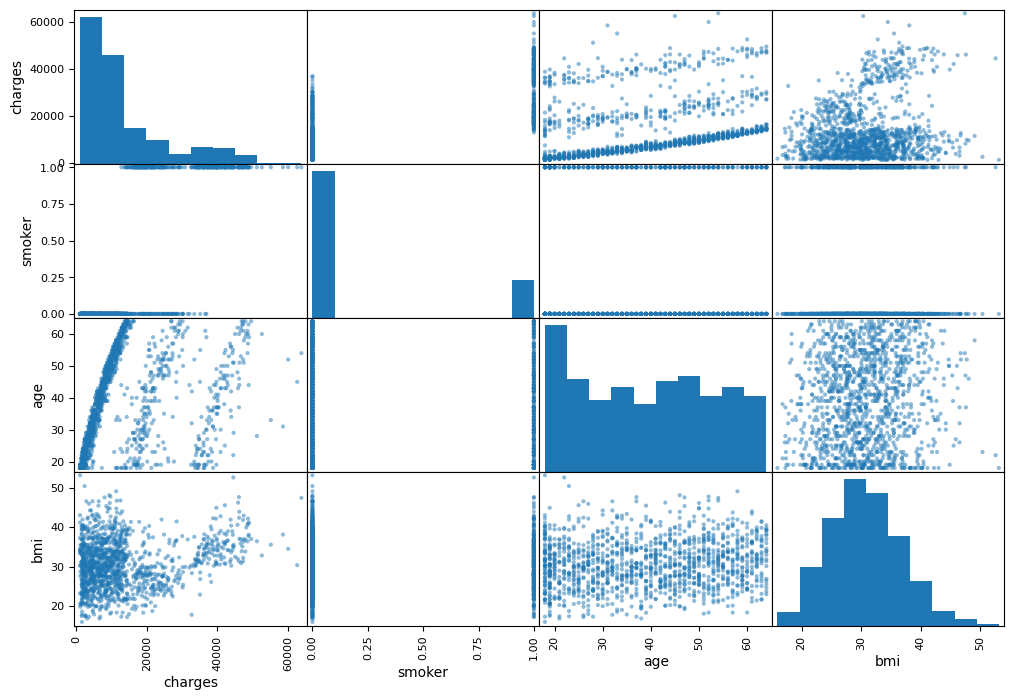

In [637]:
# from pandas.tools.plotting import scatter_matrix
from pandas.plotting import scatter_matrix

attributes = ["charges", "smoker", "age",
              "bmi"]
scatter_matrix(df[attributes], figsize=(12, 8))

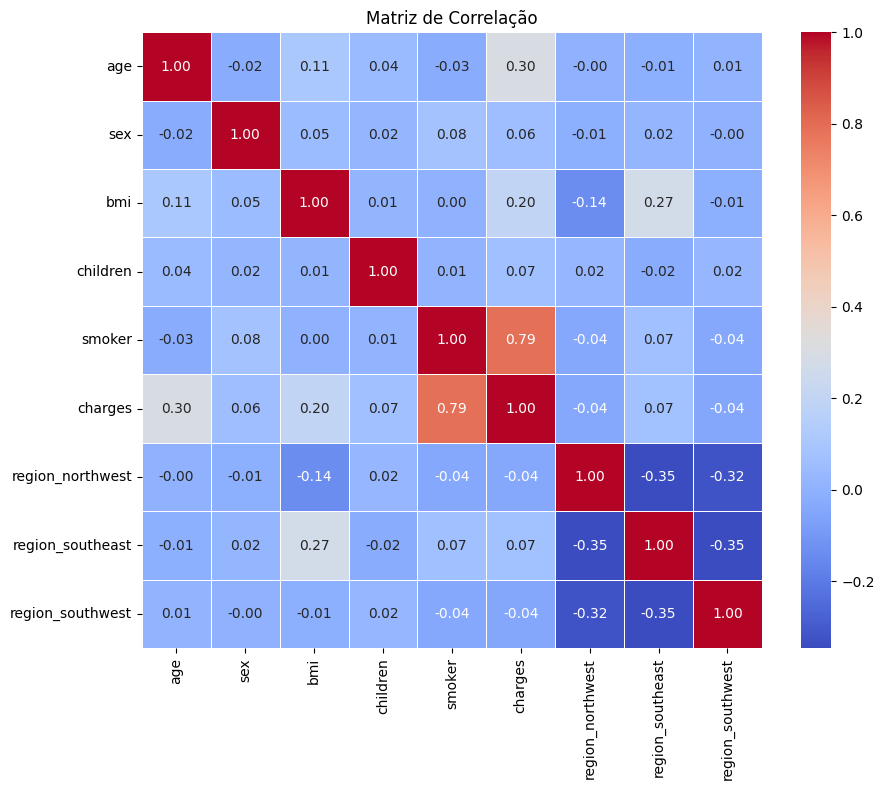

In [638]:
# Calcula a correlação entre todas as colunas numéricas
correlation_matrix = df.corr(numeric_only=True)

# Plot do heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação")
plt.show()

#Vamos plotar alguns boxplots para analisarmos como está a distribuição dessas variáveis quantitativas para descobrirmos a variação de amplitude dos dados:

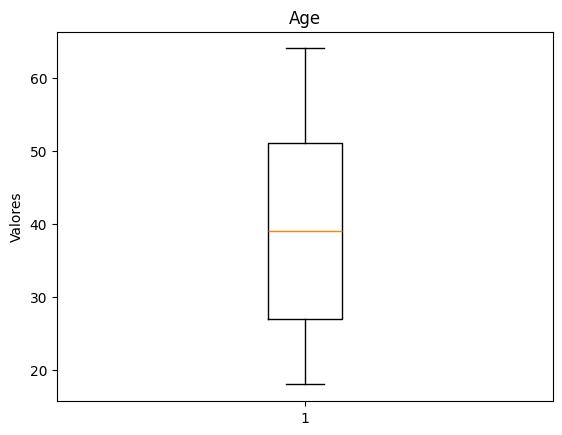

In [639]:
# Criar o gráfico de boxplot
plt.boxplot(df['age'])
plt.title('Age')
plt.ylabel('Valores')
plt.show()

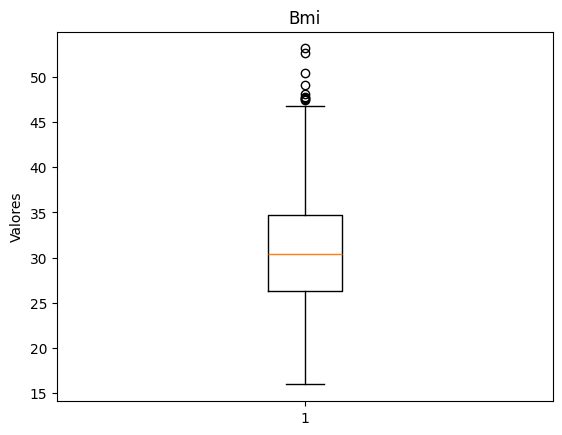

In [640]:
# Criar o gráfico de boxplot
plt.boxplot(df['bmi'])
plt.title('Bmi')
plt.ylabel('Valores')
plt.show()

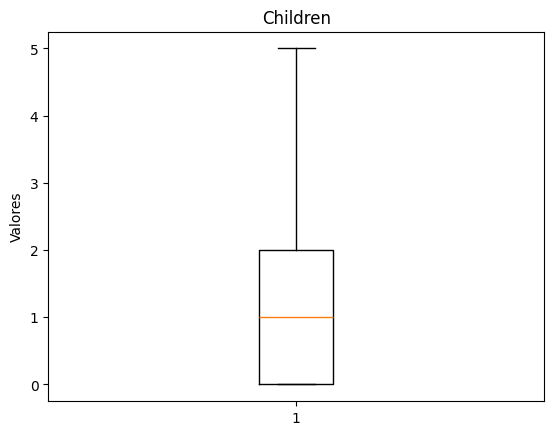

In [641]:
# Criar o gráfico de boxplot
plt.boxplot(df['children'])
plt.title('Children')
plt.ylabel('Valores')
plt.show()

Realizar a amostragem estratificada com base na categoria de smoker


In [642]:
from sklearn.model_selection import StratifiedShuffleSplit

# Criar o objeto StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Dividir os dados com base na coluna 'smoker'
for train_index, test_index in split.split(df, df["smoker"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

# Verificar a proporção de 'smoker' nas bases de treino e teste
print("Proporção de smoker na base de treino:")
print(strat_train_set["smoker"].value_counts(normalize=True))
print("\nProporção de smoker na base de teste:")
print(strat_test_set["smoker"].value_counts(normalize=True))

Proporção de smoker na base de treino:
smoker
0    0.795327
1    0.204673
Name: proportion, dtype: float64

Proporção de smoker na base de teste:
smoker
0    0.794776
1    0.205224
Name: proportion, dtype: float64


Proporção de smoker no dataframe:

In [643]:
df["smoker"].value_counts() / len(df)

smoker
0    0.795217
1    0.204783
Name: count, dtype: float64

# Verificar o dataframe
aumentou o número de colunas

In [644]:
df.shape

(1338, 9)

In [645]:
type(df)

pandas.core.frame.DataFrame

# Separando as bases em treino e teste

In [646]:
X = strat_train_set.drop(columns=["charges"])  # Features
y = strat_train_set["charges"]  # Target (valor do seguro)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [647]:
print(len(X_train), "treinamento +", len(X_test), "teste")

856 treinamento + 214 teste


# Padronização dos dados

In [648]:

scaler = StandardScaler() #chamando o metodo de padronização dos dados (média e std)

scaler.fit(X_train)# qual média e std será utilizado para o escalonamento

x_train_standard_scaled = scaler.transform(X_train)
x_test_standard_scaled  = scaler.transform(X_test)

In [649]:
x_train_standard_scaled

array([[-1.34447355,  0.99069747,  0.8113715 , ...,  1.72132593,
        -0.60254238, -0.56295921],
       [ 1.63631784,  0.99069747,  1.10281962, ..., -0.5809475 ,
        -0.60254238,  1.77632762],
       [ 1.35243294,  0.99069747, -1.21234572, ..., -0.5809475 ,
        -0.60254238,  1.77632762],
       ...,
       [-0.70573254, -1.00938988,  1.33762007, ..., -0.5809475 ,
         1.65963429, -0.56295921],
       [ 1.42340417, -1.00938988,  0.74158815, ..., -0.5809475 ,
         1.65963429, -0.56295921],
       [-1.486416  ,  0.99069747, -0.90447799, ..., -0.5809475 ,
        -0.60254238, -0.56295921]], shape=(856, 8))

# Escolhendo o melhor modelo de regressão 📈

In [650]:
# Regressão Linear
lr = LinearRegression()
lr.fit(x_train_standard_scaled, y_train)
print("R² Regressão Linear:", lr.score(x_test_standard_scaled, y_test))

# Árvore de Decisão
dt = DecisionTreeRegressor()
dt.fit(x_train_standard_scaled, y_train)
print("R² Árvore de Decisão:", dt.score(x_test_standard_scaled, y_test))

# Random Forest
rf = RandomForestRegressor(n_estimators=100)
rf.fit(x_train_standard_scaled, y_train)
print("R² Random Forest:", rf.score(x_test_standard_scaled, y_test))

# Suporte a Vetores (SVR)
svr = SVR()
svr.fit(x_train_standard_scaled, y_train)
print("R² SVR:", svr.score(x_test_standard_scaled, y_test))

# KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train_standard_scaled, y_train)
print("R² KNN:", knn.score(x_test_standard_scaled, y_test))


R² Regressão Linear: 0.7258257288527201
R² Árvore de Decisão: 0.6882481816117012
R² Random Forest: 0.8254091710979895
R² SVR: -0.13878811359100807
R² KNN: 0.7643535870686806


# Avaliando o modelo ✅
# Regressão Linear

In [651]:
from sklearn.metrics import mean_squared_error
# erro médio quadrático eleva ao quadrado a média do erro médio absoluto. Estou avaliando se os erros não são tão grandes, esses erros são penalizados.
# penaliza muito mais valores distantes da média.

predictions = lr.predict(x_test_standard_scaled)
lin_mse = mean_squared_error(y_test, predictions)
lin_rmse = np.sqrt(lin_mse) # raiz quadrada aqui
lin_rmse

np.float64(6670.1629069643195)

In [652]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_test, predictions)
lin_mae

4545.718208966546

In [653]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predictions)
print('r²',r2)

r² 0.7258257288527201


In [654]:
# Função para calcular o MAPE (Mean Absolute Percentage Error)

def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape

In [655]:
# Calcular o MAPE
mape_result = calculate_mape(y_test, predictions)

# Imprimir o resultado
print(f"O MAPE é: {mape_result:.2f}%")

O MAPE é: 42.45%


# Avaliando o modelo ✅
# Árvore de Decisão

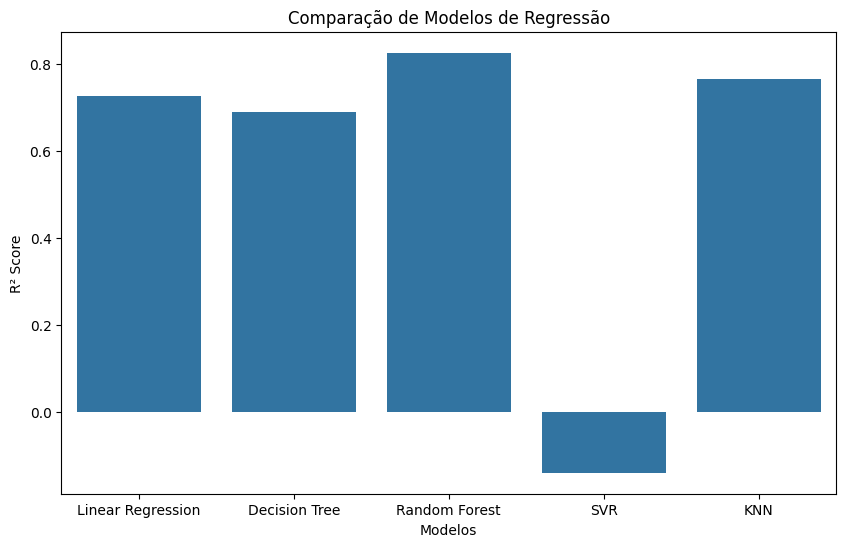

In [657]:
models = ["Linear Regression", "Decision Tree", "Random Forest", "SVR", "KNN"]
scores = [lr.score(x_test_standard_scaled, y_test), dt.score(x_test_standard_scaled, y_test), rf.score(x_test_standard_scaled, y_test), svr.score(x_test_standard_scaled, y_test), knn.score(x_test_standard_scaled, y_test)]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=scores)
plt.xlabel("Modelos")
plt.ylabel("R² Score")
plt.title("Comparação de Modelos de Regressão")
plt.show()
